In [1]:
from sklearn.base import BaseEstimator
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold

import pandas as pd
import numpy as np

from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_excel('hackaton_result_dataset.xlsx')
df.head()

,model_annotation,human_markup,audio_path,label
0,давай по россии значит на коленях быстро блять...,давай проси значит на коленях быстро блять,s3://ap-training-set/xacaton_openstt/part_1/05...,1
1,ну разве можно так с телефоном поступает,ну что ну разве можно так с телефоном поступать,s3://ap-training-set/xacaton_openstt/part_1/05...,0
2,у меня нет с собой в полном адресе я щас дома ...,у меня нет с собой полного адреса я щас из дом...,s3://ap-training-set/xacaton_openstt/part_1/05...,0
3,а я здесь кто я санитар,а я знаешь кто я санитар,s3://ap-training-set/xacaton_openstt/part_1/05...,0
4,дежурный по кузьминскому военнокомату,дежурный по кузьминскому военкомату,s3://ap-training-set/xacaton_openstt/part_1/05...,0


In [3]:
RANDOM_SEED = 42

In [4]:
X = df['model_annotation']
y = df['label']

In [5]:
# набор функций для метрик и визуализации

def plot_train_process(train_loss, val_loss, train_accuracy, val_accuracy, title_suffix=''):
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    axes[0].set_title(' '.join(['Loss', title_suffix]))
    axes[0].plot(train_loss, label='train')
    axes[0].plot(val_loss, label='validation')
    axes[0].legend()

    axes[1].set_title(' '.join(['Validation accuracy', title_suffix]))
    axes[1].plot(train_accuracy, label='train')
    axes[1].plot(val_accuracy, label='validation')
    axes[1].legend()
    plt.show()

def visualize_and_save_results(model, model_name, X_train, X_test, y_train, y_test, out_dict):
    for data_name, X, y, model in [
    ('train', X_train, y_train, model),
    ('test', X_test, y_test, model)
    ]:
        if isinstance(model, BaseEstimator):
          try:
            proba = model.predict_proba(X)[:, 1]
          except AttributeError:
            proba = model.decision_function(X) # не у всех классификаторов есть predict_proba - для них можно считать decision function, значение метрики должно быть аналогичным.
            # Из документации: https://scikit-learn.org/stable/modules/model_evaluation.html#roc-auc-binary:~:text=Otherwise%2C%20we%20can%20use%20the%20non%2Dthresholded%20decision%20values

        elif isinstance(model, nn.Module):
            proba = model(X).detach().cpu().numpy()[:, 1]
        else:
            raise ValueError('Unrecognized model type')

        auc = roc_auc_score(y, proba)

        out_dict['{}_{}'.format(model_name, data_name)] = auc
        plt.plot(*roc_curve(y, proba)[:2], label='%s AUC=%.4f' % (data_name, auc))

    plt.plot([0, 1], [0, 1], '--', color='black',)
    plt.legend(fontsize='large')
    plt.title(model_name)
    plt.grid()
    return out_dict

def get_metrics(gs, out_dict: dict) -> dict:
    """Сбор параметров и метрик обученной модели

    Args:
        gs (_type_): Экземпляр класса GridSearchCV после обучения
        out_dict (dict): Словарь с метриками на тесте и лучшими параметрами модели

    Returns:
        dict: Обновленный словарь со средними метриками на обучающей и валидационной выборках
    """
    
    val_auc = gs.best_score_
    metrics_df = pd.DataFrame(gs.cv_results_)
    total_main_metrics = metrics_df[['mean_train_score', 'mean_test_score', 'std_test_score']]
    main_metrics_dict = total_main_metrics[total_main_metrics['mean_test_score'] == val_auc].to_dict()
    out_dict.update(**main_metrics_dict)
    return out_dict

## Токенизация и эмбеддинг (sbert)

In [ ]:
from transformers import AutoTokenizer, AutoModel
import torch

In [ ]:
#Mean Pooling - Take attention mask into account for correct averaging
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0] #First element of model_output contains all token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, 1)
    sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
    return sum_embeddings / sum_mask

In [ ]:
#Sentences we want sentence embeddings for
# sentences = ['Привет! Как твои дела?',
#              'А правда, что 42 твое любимое число?']

sentences = list(X)

In [ ]:
#Load AutoModel from huggingface model repository
tokenizer = AutoTokenizer.from_pretrained("ai-forever/sbert_large_mt_nlu_ru")
model = AutoModel.from_pretrained("ai-forever/sbert_large_mt_nlu_ru")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/331 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/752 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/1.78M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.71G [00:00<?, ?B/s]

In [ ]:
#Tokenize sentences
encoded_input = tokenizer(sentences, padding=True, truncation=True, max_length=24, return_tensors='pt')

In [ ]:
#Compute token embeddings
with torch.no_grad():
    model_output = model(**encoded_input)

In [ ]:
#Perform pooling. In this case, mean pooling
sentence_embeddings = mean_pooling(model_output, encoded_input['attention_mask'])

In [ ]:
type(sentence_embeddings)

torch.Tensor

In [ ]:
emb_shape = sentence_embeddings.shape
emb_shape

torch.Size([6508, 1024])

In [ ]:
# сохраняю эмбеддинги, чтобы не пересчитывать каждый раз
sentence_embeddings_np = sentence_embeddings.numpy() #convert to Numpy array
sentence_embeddings_df = pd.DataFrame(sentence_embeddings_np) #convert to a dataframe
# sentence_embeddings_df.to_csv("/content/drive/MyDrive/MIPT/Hackathon 2 semester/data/X_embeddings.csv",index=False) #save to file
sentence_embeddings_df.to_csv('X_embeddings.csv',index=False) #save to file

## Релоад эмбеддингов и сплит выборки

In [6]:
# релоад эмбеддингов
# X_emb = pd.read_csv('/content/drive/MyDrive/MIPT/Hackathon 2 semester/data/X_embeddings.csv')
X_emb = pd.read_csv('X_embeddings.csv')
X_emb.head(3)

,0,1,2,3,4,5,6,7,8,9,...,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
0,-0.377481,0.009592,-0.046731,0.623008,0.156298,0.886241,-0.116604,0.094484,0.354349,0.368283,...,-0.932054,0.154574,0.497324,0.501176,0.238273,0.398204,0.617562,-0.301858,0.848824,0.989471
1,-0.352205,-0.191090,0.938868,-1.159469,0.840627,0.253895,-0.187263,0.472628,-0.604140,-0.504868,...,-0.287246,1.783751,-0.535041,0.236737,0.451994,0.075466,-0.525910,0.077552,0.104763,0.442214
2,-0.201619,0.140101,-0.672204,-0.327400,-0.276646,0.000594,0.388446,0.750250,0.006718,-0.330663,...,0.064791,0.273605,-0.673353,0.951182,-0.077903,0.220889,-0.159871,0.466938,-0.450167,0.855221


In [7]:
# сплит стратифицированный! На валидацию (_test) оставляем 10% датасета
X_train, X_test, y_train, y_test = train_test_split(X_emb, y, test_size=0.1, stratify=y, random_state=RANDOM_SEED)

In [8]:
print(X_train.shape)
print(X_test.shape)
print(type(X_train))

(5857, 1024)
(651, 1024)
<class 'pandas.core.frame.DataFrame'>


## PassiveAggressiveClassifier

In [9]:
from sklearn.linear_model import PassiveAggressiveClassifier

In [10]:
'''
C : This is the regularization parameter, and denotes the penalization the model will make on an incorrect prediction. default=1.0
max_iter : The maximum number of iterations the model makes over the training data. default=1000
tol : The stopping criterion. If it is set to None, the model will stop when (loss > previous_loss  –  tol). By default, it is set to 1e-3.
'''

params = {
    'C' : np.linspace(0.01, 1, 25),
    'max_iter' : [1000, 1500, 2000],
    'tol' : [1e-3, 1e-4, 1e-5]
}

In [11]:
model = PassiveAggressiveClassifier(random_state=RANDOM_SEED)

In [12]:
gs = GridSearchCV(model, param_grid=params, cv=StratifiedKFold(5), scoring='roc_auc', refit=True, return_train_score=True)
gs.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=PassiveAggressiveClassifier(random_state=42),
             param_grid={'C': array([0.01   , 0.05125, 0.0925 , 0.13375, 0.175  , 0.21625, 0.2575 ,
       0.29875, 0.34   , 0.38125, 0.4225 , 0.46375, 0.505  , 0.54625,
       0.5875 , 0.62875, 0.67   , 0.71125, 0.7525 , 0.79375, 0.835  ,
       0.87625, 0.9175 , 0.95875, 1.     ]),
                         'max_iter': [1000, 1500, 2000],
                         'tol': [0.001, 0.0001, 1e-05]},
             return_train_score=True, scoring='roc_auc')

In [13]:
best_params = gs.best_params_
print(best_params)
print(gs.best_score_)

{'C': 0.051250000000000004, 'max_iter': 1000, 'tol': 0.0001}
0.7046960775161875


In [26]:
test_val_dict = dict()
test_val_dict = get_metrics(gs, test_val_dict)
print('Тестовые и валидационные метрики из GridSearchCV:')
pd.DataFrame(test_val_dict).drop_duplicates() #нам интересно в целом оценить метрики, поэтому дубликаты можно не выводить

Тестовые и валидационные метрики из GridSearchCV:


,mean_train_score,mean_test_score,std_test_score
10,0.821889,0.704696,0.021372


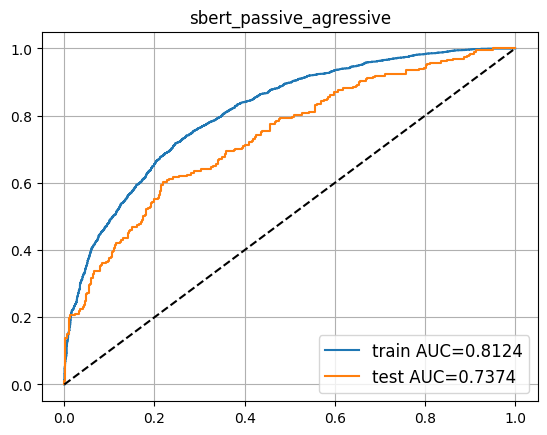

In [27]:
out_dict = dict()
out_dict = visualize_and_save_results(gs, 'sbert_passive_agressive', X_train, X_test, y_train, y_test, out_dict)

## MultinomialNB

In [28]:
from sklearn.naive_bayes import MultinomialNB

In [29]:
'''
alpha: It is the Laplace smoothing parameter which is used to avoid zero probabilities in cases where a feature doesn’t occur in a particular class in the training data. A higher value of alpha results in less aggressive smoothing which allows the model to be more sensitive to the training data.
fit_prior: This is a Boolean parameter (True/False) which determines whether to learn class prior probabilities or not. We will set it to ‘True’ so that it assumes uniform prior probabilities for classes.
force_alpha: This is also a Boolean parameter (True/False) which forces the alpha to be added to the sample counts and smoothed if it is set to ‘True’.
'''
params = {
    'alpha' : np.linspace(0, 1, 20),
    'force_alpha': [True, False]
}

model = MultinomialNB()

In [ ]:
gs = GridSearchCV(model, param_grid=params, cv=StratifiedKFold(5), scoring='roc_auc', refit=True, return_train_score=True)
gs.fit(X_train, y_train)

ValueError: 
All the 200 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
200 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/naive_bayes.py", line 776, in fit
    self._count(X, Y)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/naive_bayes.py", line 898, in _count
    check_non_negative(X, "MultinomialNB (input X)")
  File "/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py", line 1418, in check_non_negative
    raise ValueError("Negative values in data passed to %s" % whom)
ValueError: Negative values in data passed to MultinomialNB (input X)


In [30]:
# Как видно из лога, MultinomialNB не поддерживает отрицательные значения, так что со sbert нормально работать не будет.
# Здесь уже можно сделать вывод, что метод нам не подойдет, но все же закончим проверку, пропустив данные через нормализацию
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [31]:
gs = GridSearchCV(model, param_grid=params, cv=StratifiedKFold(5), scoring='roc_auc', refit=True, return_train_score=True)
gs.fit(X_train_scaled, y_train)

c:\Users\-\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\naive_bayes.py:633: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10. Use `force_alpha=True` to keep alpha unchanged.
  warnings.warn(
c:\Users\-\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\naive_bayes.py:633: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10. Use `force_alpha=True` to keep alpha unchanged.
  warnings.warn(
c:\Users\-\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\naive_bayes.py:633: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10. Use `force_alpha=True` to keep alpha unchanged.
  warnings.warn(
c:\Users\-\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\naive_bayes.py:633: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10. Use `force_alpha=True` to keep alpha unchanged.
  warnings.warn(
c:\Users\-\A

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=MultinomialNB(),
             param_grid={'alpha': array([0.        , 0.05263158, 0.10526316, 0.15789474, 0.21052632,
       0.26315789, 0.31578947, 0.36842105, 0.42105263, 0.47368421,
       0.52631579, 0.57894737, 0.63157895, 0.68421053, 0.73684211,
       0.78947368, 0.84210526, 0.89473684, 0.94736842, 1.        ]),
                         'force_alpha': [True, False]},
             return_train_score=True, scoring='roc_auc')

In [32]:
best_params = gs.best_params_
print(best_params)
print(gs.best_score_)

{'alpha': 0.0, 'force_alpha': True}
0.7174835177191815


In [33]:
test_val_dict = dict()
test_val_dict = get_metrics(gs, test_val_dict)
print('Тестовые и валидационные метрики из GridSearchCV:')
pd.DataFrame(test_val_dict).drop_duplicates() #нам интересно в целом оценить метрики, поэтому дубликаты можно не выводить

Тестовые и валидационные метрики из GridSearchCV:


,mean_train_score,mean_test_score,std_test_score
0,0.727777,0.717484,0.01387


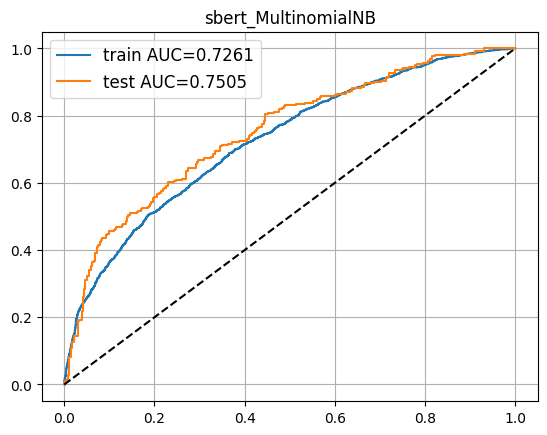

In [34]:
out_dict = dict()
out_dict = visualize_and_save_results(gs, 'sbert_MultinomialNB', X_train_scaled, X_test_scaled, y_train, y_test, out_dict)

## VotingClassifier

In [35]:
import numpy as np
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import VotingClassifier

In [36]:
clf1 = LogisticRegression(random_state=RANDOM_SEED)
clf2 = MLPClassifier(random_state=RANDOM_SEED, verbose=0)
clf3 = SGDClassifier(max_iter=1000, loss='log')

eclf = VotingClassifier(estimators=[
    ('lr', clf1),
    ('mlp', clf2),
    ('sgd', clf3)
], voting='soft')

In [37]:
params = {
    'lr__C' : np.linspace(0.01, 0.5, 4),
    'lr__class_weight' : [None,'balanced'],
    'lr__penalty' : ['l1'],
    'lr__solver' : ['liblinear'],

    'mlp__hidden_layer_sizes': [(4, 8, 16, 24)],
    'mlp__solver':['adam'],
    'mlp__activation': [ 'relu' ],
    'mlp__learning_rate': ['adaptive'],
    'mlp__early_stopping': [ True],
    'mlp__max_iter':[300],
    'mlp__learning_rate_init':[0.0002],

    'sgd__penalty' : ['l2', 'l1'],
    'sgd__alpha' : np.linspace(0.01, 0.1, 4),
    'sgd__learning_rate' : ['adaptive', 'optimal'],
    'sgd__loss' : ['log_loss'],
    'sgd__eta0' : [0.007, 0.01]
}

In [38]:
gs = GridSearchCV(estimator=eclf, param_grid=params, cv=StratifiedKFold(5), scoring='roc_auc', refit=True, return_train_score=True, n_jobs=-1)
gs.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=VotingClassifier(estimators=[('lr',
                                                     LogisticRegression(random_state=42)),
                                                    ('mlp',
                                                     MLPClassifier(random_state=42,
                                                                   verbose=0)),
                                                    ('sgd',
                                                     SGDClassifier(loss='log'))],
                                        voting='soft'),
             n_jobs=-1,
             param_grid={'lr__C': array([0.01      , 0.17333333, 0.33666667, 0.5       ]),
                         'lr__class_weight': [Non...
                         'mlp__hidden_layer_sizes': [(4, 8, 16, 24)],
                         'mlp__learning_rate': ['adaptive'],
                         'mlp__learning_rate_init': [0.0002],
                         'mlp__max_iter': [300], 'mlp__solver': ['adam'],
                         'sgd__alpha': array([0.01, 0.04, 0.07, 0.1 ]),
                         'sgd__eta0': [0.007, 0.01],
                         'sgd__learning_rate': ['adaptive', 'optimal'],
                         'sgd__loss': ['log_loss'],
                         'sgd__penalty': ['l2', 'l1']},
             return_train_score=True, scoring='roc_auc')

In [39]:
best_params = gs.best_params_
print(best_params)
print(gs.best_score_)

{'lr__C': 0.17333333333333334, 'lr__class_weight': None, 'lr__penalty': 'l1', 'lr__solver': 'liblinear', 'mlp__activation': 'relu', 'mlp__early_stopping': True, 'mlp__hidden_layer_sizes': (4, 8, 16, 24), 'mlp__learning_rate': 'adaptive', 'mlp__learning_rate_init': 0.0002, 'mlp__max_iter': 300, 'mlp__solver': 'adam', 'sgd__alpha': 0.01, 'sgd__eta0': 0.007, 'sgd__learning_rate': 'optimal', 'sgd__loss': 'log_loss', 'sgd__penalty': 'l2'}
0.782256733395775


In [40]:
test_val_dict = dict()
test_val_dict = get_metrics(gs, test_val_dict)
print('Тестовые и валидационные метрики из GridSearchCV:')
pd.DataFrame(test_val_dict).drop_duplicates() #нам интересно в целом оценить метрики, поэтому дубликаты можно не выводить

Тестовые и валидационные метрики из GridSearchCV:


,mean_train_score,mean_test_score,std_test_score
66,0.847305,0.782257,0.01169


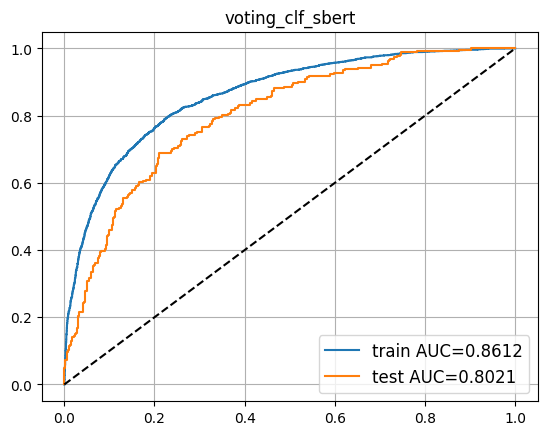

In [41]:
out_dict = dict()
out_dict = visualize_and_save_results(gs, 'voting_clf_sbert', X_train, X_test, y_train, y_test, out_dict)